In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/検索技術_最終課題/datas&models

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/検索技術_最終課題/datas&models


In [2]:
pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install janome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from janome.tokenizer import Tokenizer
import zipfile
import os.path, urllib.request as req
import glob
import os
import tensorflow_datasets as tfds
from gensim.models import word2vec
import re

In [5]:
# データセットの取得
ds = tfds.load('wiki40b/ja', split='test')

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/20 [00:00<?, ? file/s]


Dataset wiki40b downloaded and prepared to /root/tensorflow_datasets/wiki40b/ja/1.3.0. Subsequent calls will reuse this data.


In [6]:
def create_text(tf_data):
    start_paragraph = False
    for text in wiki['text'].decode().split('\n'):
      if start_paragraph:
        text = text.replace('_NEWLINE_', '\n') # _NEWLINE_は削除
        start_paragraph = False
      if text == '_START_PARAGRAPH_': # _START_PARAGRAPH_のみ取得
        start_paragraph = True
    return text

In [7]:
def mp_analysis(text, wakati_file):  # 形態素解析
  t = Tokenizer()
  results = []
  
  # テキストを一行ずつ処理する
  lines = text.split("\r\n")
  for line in lines:
    s = line
    s = re.sub(r'（.+?）', '', s) # （ ）を削除
    s = re.sub(r'《.+?》', '', s) # ルビを削除
    s = re.sub(r'［＃.+?］', '', s) # 入力注を削除
    tokens = t.tokenize(s) # 形態素解析
    # 必要な語句だけを対象とする)
    r = []
    for tok in tokens:
        if tok.base_form == "*": # 単語の基本系を採用
            w = tok.surface
        else:
            w = tok.base_form
        ps = tok.part_of_speech # 品詞情報
        hinsi = ps.split(',')[0]
        if hinsi in ['名詞', '形容詞', '動詞', '記号']:
            r.append(w)
    rl = (" ".join(r)).strip()
    results.append(rl)
    
  # 書き込み先テキストを開く
  with open(wakati_file, 'a', encoding='utf-8') as fp:
    fp.write("\n".join(results))

In [8]:
# 書き込み先テキストの初期化
wakati_file = open('wiki.wakati','w')
wakati_file.truncate(0)

# テキストファイルの読み込み
for wiki in list(ds.as_numpy_iterator())[0:1000]:
  text = create_text(wiki)
  mp_analysis(text, 'wiki.wakati')
    
# Word2Vecでモデルを作成
wiki_data = word2vec.LineSentence('wiki.wakati')
wiki_model = word2vec.Word2Vec(wiki_data, size=200, window=10, hs=1, min_count=2, sg=1)
wiki_model.save('wiki.model')
print('ok')

ok


In [25]:
# ZIPファイルをダウンロード
local = ["799_ruby_6024.zip", "53859_ruby_47309.zip", "50670_ruby_37831.zip", "43606_ruby_17004.zip", "47061_ruby_28378.zip", "49922_ruby_48217.zip", "49209_ruby_32175.zip", "45245_ruby_21882.zip", "54905_ruby_49755.zip", "3325_ruby_6457.zip"]

# 書き込み先テキストの初期化
wakati_file = open('book.wakati','w')
wakati_file.truncate(0)

0

In [26]:
for zp in local:
  # ZIPファイル内のテキストファイルを読む
  zf = zipfile.ZipFile(zp, 'r') # zipファイルを読む
  infos = zf.namelist()
  file_name = []

  for extract in infos:
    if '.txt' in extract:
      info = extract
      info.replace('[','')
      info.replace(']','')
      file_name.append(info)

  for data in file_name:
    fp= zf.open(data, 'r') # アーカイブ内のテキストを読む
    bindata = fp.read()
    book_text = bindata.decode('shift_jis') # テキストがShift_JISなのでデコード
    
    # テキストファイルの読み込み
    mp_analysis(book_text, 'book.wakati')
  
# Word2Vecでモデルを作成
book_data = word2vec.LineSentence('book.wakati')
book_model = word2vec.Word2Vec(book_data, size=200, window=10, hs=1, min_count=2, sg=1)
book_model.save('book.model')
print('ok')


ok


In [54]:
wiki_model = word2vec.Word2Vec.load('wiki.model')
book_model = word2vec.Word2Vec.load('book.model')
wiki_plot_words = []
book_plot_words = []
search_word = ['国', '人', '夢', '時']

print('wiki_model:')
for word in search_word:
    wiki_words = wiki_model.most_similar(positive=[word])
    n = [w[0] for w in wiki_words]
    wiki_plot_words.append(word)
    print(word,"=", ",".join(n))

print('book_model')
for word in search_word:
    book_words = book_model.most_similar(positive=[word])
    n = [w[0] for w in book_words]
    book_plot_words.append(word)
    print(word,"=", ",".join(n))

wiki_model:
国 = 共和,侵攻,塞ぐ,バルト,マロリー,失う,従軍,プロイセン,陸奥,復興
人 = セルビア,クロアチア,日系,レスラー,ペルシア,子ども,アラブ,ディストモ,犯罪,突破
夢 = リンク,本名,清元,好き,嵐,島崎,松岡,美人,檜山,ツイン
時 = 年生,小学生,囲碁,干潮,ミュリエル・ザズーイ,遅れる,練習,スカウト,。3,1225
book_model
国 = 人民,日本,全国,習慣,棄てる,威光,英国,食客,租税,古来
人 = 区別,偶然,実験,試み,多寡,活発,東西,恥ずかしい,元来,勤
夢 = 深い,座蒲団,なくなる,立派,痩せる,煙,呑気,記者,留る,吹き出る
時 = 牢,葉,若者,頂,並ぶ,時刻,女房,思案,縛る,捕まえる


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  app.launch_new_instance()


In [48]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [57]:
#プロットしたい単語を設定する
#以下の例は、fire,earthquakeなどを設定しています。
length = len(wiki_plot_words)
plot_words = []
for words in wiki_plot_words:
  plot_words.append([words,'r'])

wiki_plot_data = []
 
j = 0
while j < length:
    wiki_plot_data.append(wiki_model[plot_words[j][0]])
    j += 1
    

#主成分分析により２次元に圧縮する
wiki_pca = PCA(n_components=2)
wiki_pca.fit(wiki_plot_data)
wiki_data_pca= wiki_pca.transform(wiki_plot_data)
length_data = len(wiki_data_pca)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22818 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_te

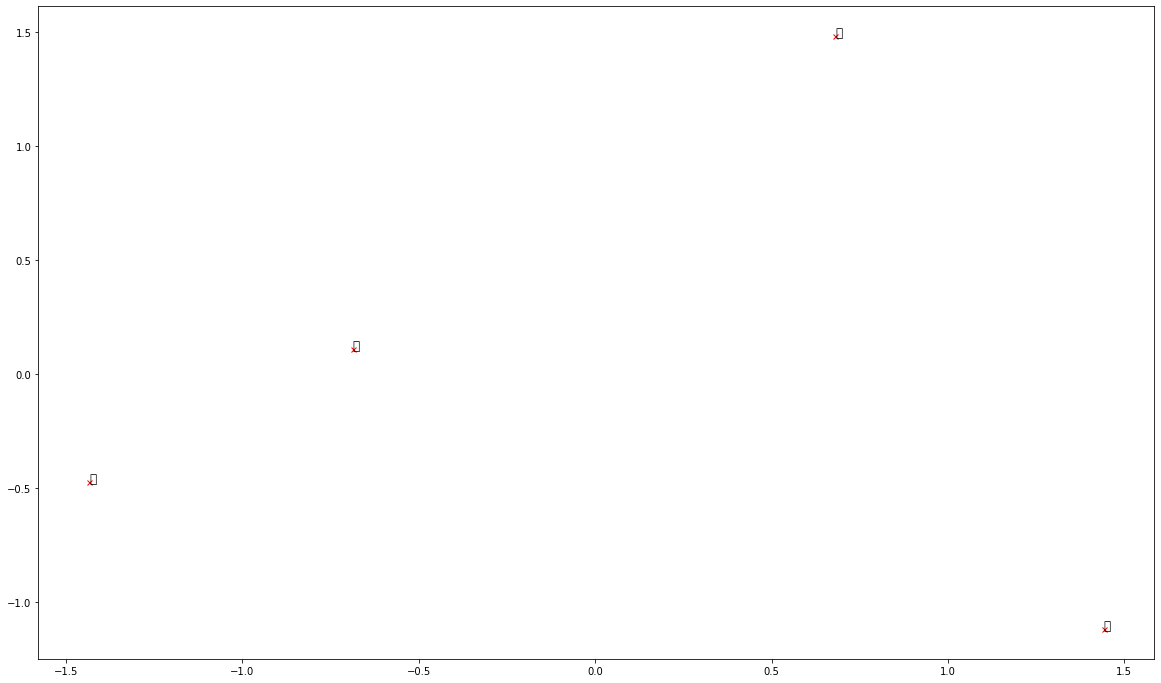

In [58]:
fig=plt.figure(figsize=(20,12),facecolor='w')

plt.rcParams['font.family'] = "MS Gothic"
i = 0
while i < length_data:
    #点プロット
    plt.plot(wiki_data_pca[i][0], wiki_data_pca[i][1], ms=5.0, zorder=2, marker="x", color=plot_words[i][1])
 
    #文字プロット
    plt.annotate(wiki_plot_words[i][0], (wiki_data_pca[i][0], wiki_data_pca[i][1]), size=12)
 
    i += 1

plt.show()